<font color='#2980B9'><center><h2>Speeding up Transformer with Optimization Strategies</h2></center></font>
<br>

<font color='#3498DB'><h3>Introduction</h3></font>

For training the state-of-the-art or SOTA models, GPU is a big necessity. And even if we can procure one from **Google Colab** or **Kaggle**, there still comes the problem of memory constraints.   

We are more or less accustomed to seeing the **OOM (Out of Memory)** or **GPU Runtime Limit Reached** errors whenever we throw a large batch, large model, longer epochs, etc. to train. 

*This notebook will foray into how we can solve these issues using various optimization strategies with in-depth analysis and code.* 
<br>

<font color='#3498DB'><h3>Problem</h3></font>

The problem is far more **apparent** when we talk about **transformers**. Transformers are extremely memory intensive. Hence, there is quite a high probability that we will run out of memory or above the runtime limit while training larger models or for longer epochs.

Like in this competition the **loss** is **oscillating/unstable**. For finding the best performing models the trick is to **evaluate** more **frequently** within each epoch than after every epoch. This is an intensive process and if the training is done in **folds** might result in GPU Runtime Limit Reached.
<br>

<font color='#3498DB'><h3>Solution</h3></font>

There are some promising **well-known** out of the box **strategies** to solve these problems and each strategy comes with its own benefits. 
 - Dyanmic Padding and Uniform Length Batching  
 - Gradient Accumulation  
 - Freeze Embedding  
 - Numeric Precision Reduction 
 - Gradient Checkpointing
 
*Note 1: All these optimizations are focussed on single-GPU only. These optimizations will work on multi-GPU as well but multi-GPU setting has more advanced techniques like DataParallel, DataParallelModel, ZeRO etc. which work much better for accelarating Transformers.*

*Note 2: Gradient Checkpointing increases computation time but it helps to fit larger batch size in single pass. Thus, I've included this.*

<br>

<font color='#3498DB'><h3>Contents</h3></font>
- [**Dynamic Padding and Uniform Length Batching (Smart Batching)**](#section1)
  - [Introduction](#section10)
      - [Dyanmic Padding](#section11)
      - [Uniform Length Batching](#section12)
  - [Read Dataset](#section13)
  - [Load Tokenizer](#section14)
  - [Tokenize without Padding](#section15)
  - [Sort by Length](#section16)
  - [Random Batch Selection](#section17)
  - [Add Padding](#section18)
    - [Comparison I](#section18a)
  - [Unified Function - **make_smart_batches**](#section19)
  - [Smart Batching with DataLoader, Collater, Sampler](#section110)
    - [Components](#section110a)
    - [Comparison II](#section110b)
  - [Conclusion](#section111)
  - [References & Resources](#section112)
- [**Freeze Embedding**](#section2)
  - [Introduction](#section20)
  - [Idea](#section21)
  - [Splits Analysis](#section22)
  - [Implementation](#section23)
  - [Conclusion](#section24)
  - [References & Resources](#section25)
- [**Numeric Precision Reduction**](#section3)
  - [Introduction](#section30)
  - [Floating Point Representation](#section31)
  - [How to Use?](#section32)
  - [Special Case](#section33)
  - [References & Resources](#section34)
- [**Gradient Accumulation**](#section4)
  - [Introduction](#section40)
  - [Implementation](#section41)
  - [References & Resources](#section42)
- [**Gradient Checkpointing**](#section5)
  - [Introduction](#section50)
  - [Idea](#section51)
  - [References & Resources](#section52)
- [**Ending Notes**](#section6)

<font color='#3498DB'><h3>What's New?</h3></font>
1. [SWA, Apex AMP & Interpreting Transformers in Torch](https://www.kaggle.com/rhtsingh/swa-apex-amp-interpreting-transformers-in-torch) notebook is an implementation of the Stochastic Weight Averaging technique with NVIDIA Apex on transformers using PyTorch. The notebook also implements how to interactively interpret Transformers using LIT (Language Interpretability Tool) a platform for NLP model understanding.   
It has in-depth explanations and code implementations for,
 - SWA 
 - Apex AMP
 - Weighted Layer Pooling
 - MADGRAD Optimizer
 - Grouped LLRD
 - Language Interpretibility Tool
    - Attention Visualization
    - Saliency Maps
    - Integrated Gradients
    - LIME 
    - Embedding Space (UMAP & PCA)
    - Counterfactual generation
    - And many more ...

2. [Utilizing Transformer Representations Efficiently](https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently) notebook will show many different ways these outputs and hidden representations can be utilized to do much more than just adding an output layer. It has code implementations and detailed explanations for all the below techniques,
 - Pooler Output  
 - Last Hidden State Output  
    - CLS Embeddings  
    - Mean Pooling  
    - Max Pooling  
    - Mean + Max Pooling  
    - Conv1D Pooling  
 - Hidden Layers Output  
    - Layerwise CLS Embeddings  
    - Concatenate Pooling  
    - Weighted Layer Pooling  
    - LSTM / GRU Pooling  
    - Attention Pooling  
    - WKPooling  

3. [On Stability of Few-Sample Transformer Fine-Tuning](https://www.kaggle.com/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning) notebook goes over various remedies to increase few-sample fine-tuning stability and they show a significant performance improvement over simple finetuning methods. The methods explained in the notebook are - 
 - Debiasing Omission In BertADAM
 - Re-Initializing Transformer Layers
 - Utilizing Intermediate Layers
 - Layer-wise Learning Rate Decay (LLRD) 
 - Mixout Regularization
 - Pre-trained Weight Decay
 - Stochastic Weight Averaging. 
 
<font color='#3498DB'><h3>Fixes</h3></font>

 - <font color='#3498DB'>6/6/2021 - Fixed Dynamic Padding + Uniform Length Bacthing with DataLoader</font>
   - Issue: Once the SmartBatchingSampler is initalized it returns the same sequence of randomly shuffled batches due to which randomness is reduced.
   

<font color='#3498DB'><a id="section1"><h2>Dynamic Padding and Uniform Length Batching</h2></a></font>

<font color='#3498DB'><a id="section10"><h3>Introduction</h3></a></font>
Training neural networks on a batch of sequences requires them to have the exact same length to build the batch matrix representation. Because real life NLP datasets are always made of texts of variable lengths, we often need to make some sequences shorter by truncating them, and some others longer by adding at the end a repeated fake token called “pad” token. 

Because the pad token doesn’t represent a real word, when most computations are done, before computing the loss, we erase the pad token signal by multiplying it by 0 through the “attention mask” matrix for each sample, which identifies the [PAD] tokens and tells Transformer to ignore them.

![Fixed Padding](https://drive.google.com/uc?export=view&id=1UaVW3gxTSAD0E9CrCX48kn6QF_L_slP9)

For e.g., In this competition, in order to feed multiple samples into RoBERTa at once, I am padding out all of the sentences to a "fixed length" of 250. 
This is the standard approach that I’ve used in all of my examples, and it’s certainly the simplest to implement, code-wise.

<font color='#3498DB'><a id="section11"><h3>Dynamic Padding</h3></a></font>
Here we limit the number of added pad tokens to reach the length of the longest sequence of each mini batch instead of a fixed value set for the whole train set Because the number of added tokens changes across mini batches, we call it "dynamic" padding.

![Dyanmic Padding](https://drive.google.com/uc?export=view&id=1UfJJ2sj1w6prvwQPwyqbQCgJbJ9qIC9V)


<font color='#3498DB'><a id="section12"><h3>Uniform Length Batching</h3></a></font>

We push the logic futher by generating batches made of similar length sequences so we avoid extreme cases where most sequences in the mini batch are short and we are required to add lots of pad tokens to each of them because 1 sequence of the same mini batch is very long.

![Uniform Length Batching](https://drive.google.com/uc?export=view&id=1UjQaOAkN-zPh10fSoXmZ-68jMdFLq2y_)

*Note: In the above illustration the selected batches are in sequence, but we’ll actually be selecting them more randomly, to allow for more randomness to the order of the training data.*

**That's it, we are done with theory and from here onwards, we will understand by implementing in code.**

<font color='#3498DB'><a id="section13"><h3>Read Dataset</h3></a></font>

Here we will read our competition dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer
from IPython.display import clear_output

train = pd.read_csv('../input/commonlitreadabilityprize/train.csv', low_memory=False)
test = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv', low_memory=False)

<font color='#3498DB'><a id="section14"><h3>Load Tokenizer</h3></a></font>

We'll be using RoBERTa-base tokenizer.

In [2]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
clear_output()

<font color='#3498DB'><a id="section15"><h3>Tokenize Without Padding</h3></a></font>

<font color='#3498DB'><a id="section15a"><h4>Peak GPU Memory Use</h4></a></font>
Even when applying this technique, we may still want to truncate our inputs to a certain maximum length. All it takes is one batch that's too long to fit on the GPU, and our training will fail! Hence, it makes sense to truncate to something lower than 512, even with smart batching. 

*Note: We don't need to be concerned about this during training in this competition since the highest sequence length is less than 350.*

<font color='#3498DB'><a id="section15b"><h4>Tokenize, but don't pad</h4></a></font>

We’re going to start by tokenizing all of the samples and mapping the tokens to their IDs. We’re also going to truncate the sequences to our chosen max_len, and we’re going to add the special tokens. But we are **not padding** yet!

In [3]:
def good_update_interval(total_iters, num_desired_updates):
    # find intervals for printing updates
    exact_interval = total_iters / num_desired_updates
    order_of_mag = len(str(total_iters)) - 1
    round_mag = order_of_mag - 1
    update_interval = int(round(exact_interval, -round_mag))
    if update_interval == 0:
        update_interval = 1
    return update_interval

In [4]:
input_ids = []

train_text = train.excerpt.values.tolist()
train_targets = train.target.values.tolist()
max_len = 350

print('Tokenizing {:,} training samples...'.format(len(train_text)))

update_interval = good_update_interval(total_iters=len(train_text), num_desired_updates=5)

for text in train_text:
    if ((len(input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(input_ids)))

    input_id = tokenizer.encode(
        text=text,           
        add_special_tokens=True, 
        max_length=max_len,  
        truncation=True,     
        padding=False
    )       
                                 
    input_ids.append(input_id)
    
print('DONE.')
print('{:>10,} samples'.format(len(input_ids)))

Tokenizing 2,834 training samples...
  Tokenized 0 samples.
  Tokenized 600 samples.
  Tokenized 1,200 samples.
  Tokenized 1,800 samples.
  Tokenized 2,400 samples.
DONE.
     2,834 samples


<font color='#3498DB'><a id="section16"><h3>Sort by length</h3></a></font>

Let’s look at the lengths of the samples in their original, unsorted order.
The below plot simply confirms that the sample lengths do vary significantly, and that they are unsorted.

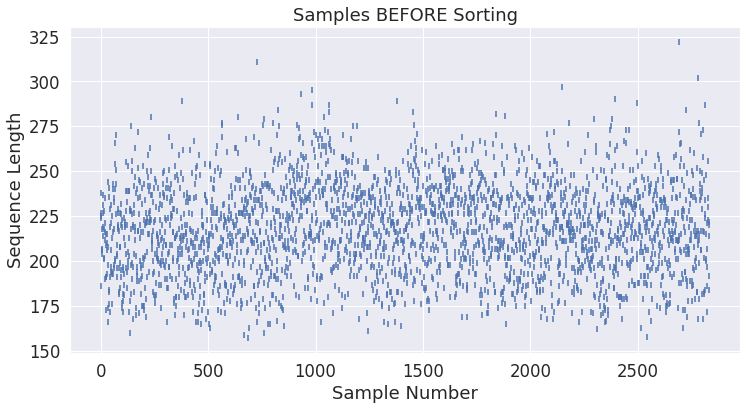

In [5]:
unsorted_lengths = [len(x) for x in input_ids]
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

Now we’ll sort the examples by length so that we can create batches with equal (or at least similar) lengths and generate the same plot again.

In [6]:
sorted_input_ids = sorted(zip(input_ids, train_targets), key=lambda x: len(x[0]))
print('Shortest sample:', len(sorted_input_ids[0][0]))
print('Longest sample:', len(sorted_input_ids[-1][0]))
sorted_lengths = [len(s[0]) for s in sorted_input_ids]

Shortest sample: 157
Longest sample: 322


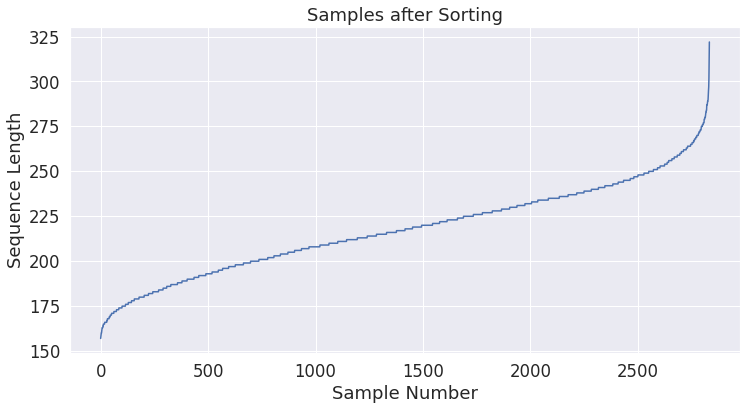

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

<font color='#3498DB'><a id="section17"><h3>Random Batch Selection</h3></a></font>

Now we’re ready to select our batches.
Rather than dividing the batches up in order, we will still add a degree of **randomness** to our selection.

Here’s the process:

 - Pick a random starting point in the (sorted!) list of samples.
 - Grab a contiguous batch of samples starting from that point.
 - Delete those samples from the list, and repeat until all of the samples have been grabbed.
 
This will result in some **fragmentation** of the list, which means it won’t be quite as efficient as if we just sliced up the batches in sorted order.

In [8]:
batch_size = 24
import random

batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

while len(sorted_input_ids) > 0:  
    if ((len(batch_ordered_sentences) % 50) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    to_take = min(batch_size, len(sorted_input_ids))
    select = random.randint(0, len(sorted_input_ids) - to_take)
    batch = sorted_input_ids[select:(select + to_take)]
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])
    del sorted_input_ids[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 24
  Selected 0 batches.
  Selected 50 batches.
  Selected 100 batches.

  DONE - 119 batches.


<font color='#3498DB'><a id="section18"><h3>Add Padding</h3></a></font>

We’ve created our batches, but many of them will contain sequences of different lengths. In order to leverage the GPUs parallel processing of batches, all of the sequences within a batch need to be the same length.

This means we need to do some **padding!**

We’ll also create our attention masks here, and cast everything to PyTorch tensors in preparation for our fine-tuning step.

In [9]:
import torch

inputs = []
attn_masks = []
targets = []

for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
    batch_padded_inputs = []
    batch_attn_masks = []
    max_size = max([len(sen) for sen in batch_inputs])
    for sen in batch_inputs:
        num_pads = max_size - len(sen)
        padded_input = sen + [tokenizer.pad_token_id]*num_pads
        attn_mask = [1] * len(sen) + [0] * num_pads
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)
    inputs.append(torch.tensor(batch_padded_inputs))
    attn_masks.append(torch.tensor(batch_attn_masks))
    targets.append(torch.tensor(batch_labels))

<font color='#3498DB'><a id="section18a"><h4>Comparison</h4></a></font>
Now that our data is ready, we can calculate the total number of tokens in the training data after using smart batching.

In [10]:
padded_lengths = []
for batch in inputs:
    for s in batch:
        padded_lengths.append(len(s))

smart_token_count = np.sum(padded_lengths)
fixed_token_count = len(train_text) * max_len

prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.2%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 991,900
  Smart Batching: 626,236  (36.87% less)


<font color='#3498DB'><a id="section19"><h3>All in One - make_smart_batches</h3></a></font>

This function combines all of the steps from the “Smart Batching” section into a single (re-usable) function. You can use this in your own Notebook for applying smart batching to both your training and test sets.

Click *show hidden code.*

In [11]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_len,      # Do Truncate!
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)

(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_text, train_targets, batch_size)

clear_output()

<font color='#3498DB'><a id="section110"><h3>Smart Batching with DataLoader, Collator, Sampler</h3></a></font>

This section is an attempt to implement the above methodology of “smart batching” in a more formal way with the PyTorch **DataLoader** class.
<br>

<font color='#3498DB'><a id="section110a"><h4>Components</h4></a></font>
We will have 4 major components that will work together,
  - Dataset - Stores the samples and their corresponding labels. 
  - DataLoader - Wrap an iterable around the Dataset to enable easy access to the samples.
  - Sampler -  Specify the sequence of indices that will be used in data loading.
  - Collator -  Collate lists of samples into batches.
   
*Note: To make the code compact the dataloader is inside "SmartBatchingDataset" and one can easily take it outside.*

In [12]:
import random
import numpy as np
import multiprocessing
import more_itertools

import torch
import torch.nn as nn
from torch.utils.data import Sampler, Dataset, DataLoader

**SmartBatchingDataset** will store the samples in by tokenzing excerpts and converting into sequences.

In [13]:
class SmartBatchingDataset(Dataset):
    def __init__(self, df, tokenizer):
        super(SmartBatchingDataset, self).__init__()
        self._data = (
            f"{tokenizer.bos_token} " + df.excerpt + f" {tokenizer.eos_token}" 
        ).apply(tokenizer.tokenize).apply(tokenizer.convert_tokens_to_ids).to_list()
        self._targets = None
        if 'target' in df.columns:
            self._targets = df.target.tolist()
        self.sampler = None

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        if self._targets is not None:
            return self._data[item], self._targets[item]
        else:
            return self._data[item]

    def get_dataloader(self, batch_size, max_len, pad_id):
        self.sampler = SmartBatchingSampler(
            data_source=self._data,
            batch_size=batch_size
        )
        collate_fn = SmartBatchingCollate(
            targets=self._targets,
            max_length=max_len,
            pad_token_id=pad_id
        )
        dataloader = DataLoader(
            dataset=self,
            batch_size=batch_size,
            sampler=self.sampler,
            collate_fn=collate_fn,
            num_workers=(multiprocessing.cpu_count()-1),
            pin_memory=True
        )
        return dataloader

**SmartBatchingSampler** will sort the sequences by length, make batches of size "batch_size", shuffle the batch and return indices.

In [14]:
class SmartBatchingSampler(Sampler):
    def __init__(self, data_source, batch_size):
        super(SmartBatchingSampler, self).__init__(data_source)
        self.len = len(data_source)
        sample_lengths = [len(seq) for seq in data_source]
        argsort_inds = np.argsort(sample_lengths)
        self.batches = list(more_itertools.chunked(argsort_inds, n=batch_size))
        self._backsort_inds = None
    
    def __iter__(self):
        if self.batches:
            last_batch = self.batches.pop(-1)
            np.random.shuffle(self.batches)
            self.batches.append(last_batch)
        self._inds = list(more_itertools.flatten(self.batches))
        yield from self._inds

    def __len__(self):
        return self.len
    
    @property
    def backsort_inds(self):
        if self._backsort_inds is None:
            self._backsort_inds = np.argsort(self._inds)
        return self._backsort_inds

**SmartBatchingCollate** will add padding upto highest sequence length, make attention masks, targets for each sample in batch. 

In [15]:
class SmartBatchingCollate:
    def __init__(self, targets, max_length, pad_token_id):
        self._targets = targets
        self._max_length = max_length
        self._pad_token_id = pad_token_id
        
    def __call__(self, batch):
        if self._targets is not None:
            sequences, targets = list(zip(*batch))
        else:
            sequences = list(batch)
        
        input_ids, attention_mask = self.pad_sequence(
            sequences,
            max_sequence_length=self._max_length,
            pad_token_id=self._pad_token_id
        )
        
        if self._targets is not None:
            output = input_ids, attention_mask, torch.tensor(targets)
        else:
            output = input_ids, attention_mask
        return output
    
    def pad_sequence(self, sequence_batch, max_sequence_length, pad_token_id):
        max_batch_len = max(len(sequence) for sequence in sequence_batch)
        max_len = min(max_batch_len, max_sequence_length)
        padded_sequences, attention_masks = [[] for i in range(2)]
        attend, no_attend = 1, 0
        for sequence in sequence_batch:
            # As discussed above, truncate if exceeds max_len
            new_sequence = list(sequence[:max_len])
            
            attention_mask = [attend] * len(new_sequence)
            pad_length = max_len - len(new_sequence)
            
            new_sequence.extend([pad_token_id] * pad_length)
            attention_mask.extend([no_attend] * pad_length)
            
            padded_sequences.append(new_sequence)
            attention_masks.append(attention_mask)
        
        padded_sequences = torch.tensor(padded_sequences)
        attention_masks = torch.tensor(attention_masks)
        return padded_sequences, attention_masks

Here we create **Dataset** and **DataLoader**, iterate over our dataloader, check the total number of tokens and, do comparison study.


In [16]:
dataset = SmartBatchingDataset(train, tokenizer)
dataloader = dataset.get_dataloader(batch_size=24, max_len=max_len, pad_id=tokenizer.pad_token_id)

padded_lengths = []
for batch_idx, (input_ids, attention_mask, targets) in enumerate(dataloader):
    for s in input_ids:
        padded_lengths.append(len(s))

smart_token_count = np.sum(padded_lengths)
fixed_token_count = len(train_text) * max_len

prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.2%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 991,900
  Smart Batching: 621,694  (37.32% less)


<font color='#3498DB'><a id="section110b"><h4>Comparison II</h4></a></font>

In comparison to above technique of random batch selection we don't have any framentation in case of DataLoader but, randomness is reduced.

 - **Fixed Padding (MaxLen-350 & BS-24):**  991,900 tokens   
 - **Smart Batching with Random Batch:** 623,780  (37.11% less)
 - **Smart Batching with DataLoader:**   621,694  (37.32% less)  

<font color='#3498DB'><a id="section111"><h3>Conclusion</h3></a></font>
It has been shown that this technique constantly provides significant time reduction without reducing (in some cases even improves) accuracy. This technique is a low hanging fruit that should be widely used by Transformer users.

<font color='#3498DB'><a id="section112"><h3>References and Resources</h3></a></font>
 
 - [**Smart Batching Tutorial - Speed Up BERT Training**](http://mccormickml.com/2020/07/29/smart-batching-tutorial/#42-tokenize-without-padding) by Chris McCormick. This is the main source of almost everything you're seeing above except for DataLoader part. Suggest to check his YouTube channel and other Blog articles as well.
 - [Divide Hugging Face Transformers training time by 2 or more](https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e) by Michaël Benesty. The inspration of Chris McCormick Smart Batching tutorial.
   - [Colab Notebook](https://github.com/ELS-RD/transformers-notebook/blob/master/Divide_Hugging_Face_Transformers_training_time_by_2_or_more.ipynb) 
   - [GitHub Gist](https://gist.github.com/pommedeterresautee/1a334b665710bec9bb65965f662c94c8)
 - [Accelerating recurrent neural network training using sequence bucketing and multi-GPU data parallelization](https://arxiv.org/abs/1708.05604)
 - [Jigsaw Multilingual Toxic Comment Classification - 4th Place Solution](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160980)
 - [Speed up your RNN with Sequence Bucketing](https://www.kaggle.com/bminixhofer/speed-up-your-rnn-with-sequence-bucketing)
 - [Better Batches with PyTorchText BucketIterator](https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a#:~:text=%F0%9F%8D%87%20Better%20Batches%20with%20PyTorchText%20BucketIterator,-How%20to%20use&text=This%20allows%20us%20to%20provide,gpt2%2C%20xlnet%2C%20etc.)
 - [Tensorflow-esque bucket by sequence length](https://discuss.pytorch.org/t/tensorflow-esque-bucket-by-sequence-length/41284)

<font color='#3498DB'><a id="section2"><h2>Freeze Embedding</h2></a></font>

<font color='#3498DB'><a id="section20"><h3>Introduction</h3></a></font>
Freezing the embedding matrix during the fine-tuning of a pre-trained language model, yes its that simple. Freezing Embedding Layer of transformers can save the GPU memory so that one can use bigger batchsize when training, while speeding up the training process.

<font color='#3498DB'><a id="section21"><h3>Idea</h3></a></font>
 - The intuition behind this is that the embedding layer contains an independent representation of each token and the vectors for tokens with similar meanings should be learned to be close in the embeddings space during pre-training to be used in a pretty similar way by the further layers. But when you have not a good amount of labeled data or a small corpus that is common for real-world use cases, most probably the data on which you will do the inference will contain some tokens that were not presented in the train set. Probably some of these new tokens will have the synonym pairs in your labeled data, but gradient updates can destroy this type of connection learned by the language model.
 
 - The other is since we are freezing the embedding matrix which itself contains huge number of parameters, gradient updates will not take place and hence will result in lesser computation times and one can utilize larger batch size.
 
<font color='#3498DB'><a id="section22"><h3>Splits Analysis</h3></a></font>
First of all, we will split the data using the KFold strategy that I have been using in my other notebooks and do some analysis for better understanding the first idea.

In [17]:
!pip install -q matplotlib_venn

from itertools import chain
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [18]:
train = pd.read_csv('../input/commonlitreadabilityprize/train.csv', low_memory=False)
test = pd.read_csv('../input/commonlitreadabilityprize/test.csv', low_memory=False)

We convert our excerpts to corresponding input ids using our roberta tokenizer,

In [19]:
input_ids = (
    f"{tokenizer.bos_token} " + train.excerpt + f" {tokenizer.eos_token}"
).apply(tokenizer.tokenize).apply(tokenizer.convert_tokens_to_ids).to_list()

train['input_ids'] = input_ids

And we create 5-Kfold split using random state - 2021

In [20]:
def create_folds(data, num_splits):
    data["kfold"] = -1
    kf = model_selection.KFold(n_splits=num_splits, shuffle=True, random_state=2021)
    for fold, (train_index, valid_index) in enumerate(kf.split(X=data)):
        data.loc[valid_index, 'kfold'] = fold
    return data
train = create_folds(train, num_splits=5)

We are going to check the tokens overlap of train and validation set tokens for each of our folds. 

Click *show hidden code* to view code.

In [21]:
def create_features_targets(train, fold):
    # function to separate train and validation data for a fold
    features_train = train[train.kfold!=fold]['input_ids'].tolist()
    features_val = train[train.kfold==fold]['input_ids'].tolist()
    targets_train = train[train.kfold!=fold]['target'].tolist()
    targets_val = train[train.kfold==fold]['target'].tolist()
    return features_train, targets_train, features_val, targets_val

# create train and validation features for each fold
features_train1, targets_train1, features_val1, targets_val1 = create_features_targets(train, 0)
features_train2, targets_train2, features_val2, targets_val2 = create_features_targets(train, 1)
features_train3, targets_train3, features_val3, targets_val3 = create_features_targets(train, 2)
features_train4, targets_train4, features_val4, targets_val4 = create_features_targets(train, 3)
features_train5, targets_train5, features_val5, targets_val5 = create_features_targets(train, 4)

# create set of unique input ids for each train and validation data
features_train1_set, features_val1_set = set(chain.from_iterable(features_train1)), set(chain.from_iterable(features_val1))
features_train2_set, features_val2_set = set(chain.from_iterable(features_train2)), set(chain.from_iterable(features_val2))
features_train3_set, features_val3_set = set(chain.from_iterable(features_train3)), set(chain.from_iterable(features_val3))
features_train4_set, features_val4_set = set(chain.from_iterable(features_train4)), set(chain.from_iterable(features_val4))
features_train5_set, features_val5_set = set(chain.from_iterable(features_train5)), set(chain.from_iterable(features_val5))

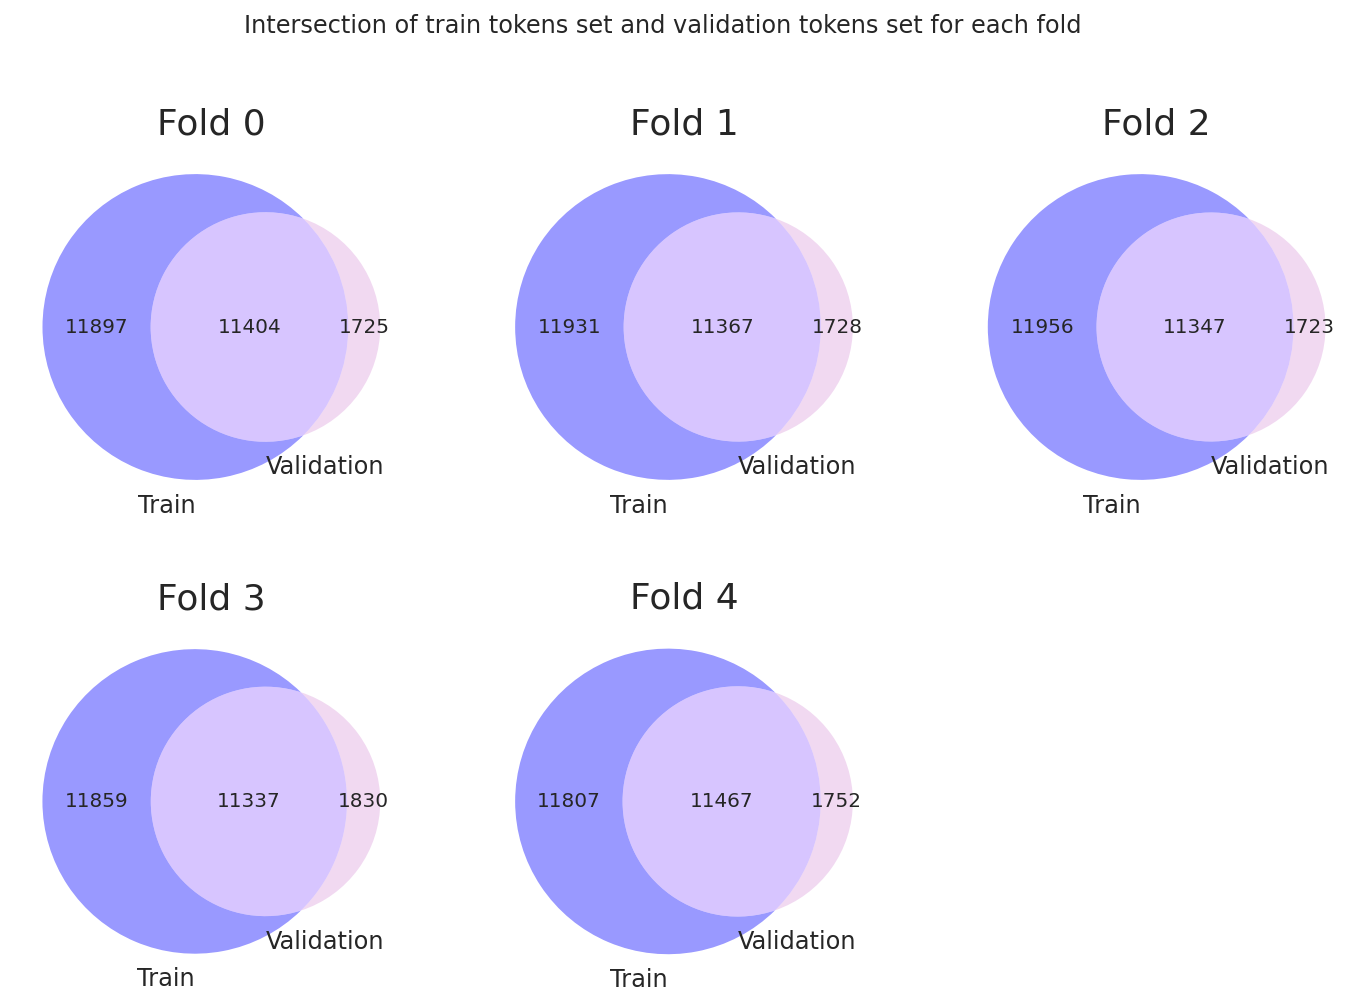

In [22]:
plt.figure(figsize=(12, 8))

plt.suptitle("Intersection of train tokens set and validation tokens set for each fold")

plt.subplot(231)
venn2(
    [features_train1_set, features_val1_set],
    set_labels=("Train", "Validation"),
    set_colors=("blue", "plum")
)
plt.title('Fold 0')

plt.subplot(232)
venn2(
    [features_train2_set, features_val2_set],
    set_labels=("Train", "Validation"),
    set_colors=("blue", "plum")
)
plt.title('Fold 1')

plt.subplot(233)
venn2(
    [features_train3_set, features_val3_set], 
    set_labels=("Train", "Validation"),
    set_colors=("blue", "plum")
)
plt.title('Fold 2')

plt.subplot(234)
venn2(
    [features_train4_set, features_val4_set], 
    set_labels=("Train", "Validation"), 
    set_colors=("blue", "plum")
)
plt.title('Fold 3')

plt.subplot(235)
venn2(
    [features_train5_set, features_val5_set], 
    set_labels=("Train", "Validation"), 
    set_colors=("blue", "plum")
)
plt.title('Fold 4')

plt.show()

We can see that for each fold number of unseen tokens is greater than 1700 for each split. This means that there are lots of unseen tokens in the validation set than the train set and in cases like these Freeze Embedding truly shines.

<font color='#3498DB'><a id="section23"><h3>Implementation</h3></a></font>

Here we are going to look at how we can implement Freeze Embedding. The implementation is pretty straightforward and only requires us to freeze base model embeddings.

In [23]:
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification

freeze_embedding = True
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(
    _pretrained_model, config=config
)
model.base_model.embeddings.requires_grad_(not freeze_embedding)

clear_output()

<font color='#3498DB'><a id="section24"><h3>Conclusion</h3></a></font>

It’s a good idea to freeze the embedding matrix when you fine-tune some pre-trained language models, especially with a large vocabulary. It won't give you superior improvements but you can try it for some Kaggle competition. 

This setup looks the same as with no freezing and you can save your time for training and include larger batch sizes which is pretty important.

<font color='#3498DB'><a id="section25"><h3>Resources and References</h3></a></font>

 - [Jigsaw Multilingual Toxic Comment Classification 10th Place Solution](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/161100)
 - [Semi-Frozen Embeddings for NLP Transfer Learning](https://medium.com/commetric/semi-frozen-embeddings-for-nlp-transfer-learning-49fcfeec3f1b)
 - [To Tune or Not to Tune?
Adapting Pretrained Representations to Diverse Tasks](https://arxiv.org/pdf/1903.05987.pdf)
 - [What Would Elsa Do? Freezing Layers During Transformer Fine-Tuning](https://arxiv.org/pdf/1911.03090.pdf)
 

<font color='#3498DB'><a id="section3"><h2>Numeric Precision Reduction</h2></a></font>

<font color='#3498DB'><a id="section30"><h3>Introduction</h3></a></font>
Numeric Precision Reduction means yielding speedups through the use of floating point reduction and quantization. This is perhaps the most-general method for yielding prediction-time speedups. 
 
 In past years poor support for float16 operations on GPU hardware meant that reducing the precision of weights and activations was often counter-productive, but the introduction of the NVIDIA Volta and Turing architectures with Tensor Cores means modern GPUs are now well equipped for efficient float16 arithmetic.

<font color='#3498DB'><a id="section31"><h3>Floating Point Representation</h3></a></font>
 Floating point types store numeric information of three types – the sign, exponent, and fraction.  Traditional float32 representations have 8 bits and 23 bits respectively to represent the exponent and fraction.  Traditional float16 representations (the format used for NVIDIA hardware) roughly halve both the exponent and fraction components of the representation. TPUs use a variant called bfloat16. 
 
Most of a transformer network can be naively converted to float16 weights and activations with no accuracy penalty.
 
![fp16](https://www.pragmatic.ml/content/images/2020/04/image-2.png)

  Small portions of the network – in particular, portions of the softmax operation – must remain in float32.  This is because the sum of a large number of small values (our logits) can be a source of accumulated error. Because both float16 and float32 values are used, this method is often referred to as "mixed-precision" training. 
  
Less precise numeric representations enable speedups from two sources.
 - Native half-precision instructions
 - Larger batch sizes thanks to more compact representations 
 
<font color='#3498DB'><a id="section32"><h3>How to Use?</h3></a></font>
Mixed precision primarily benefits Tensor Core-enabled architectures (Volta, Turing, Ampere). AMP shows significant (2-3X) speedup on those architectures. On earlier architectures (Kepler, Maxwell, Pascal), one may observe a modest speedup. One can run `!nvidia-smi` to display the GPU’s architecture.

 - [NVIDIA-apex](https://github.com/NVIDIA/apex) - NVIDIA has published a rather extensive suite of benchmarks relating to floating point precision reduction – in practice this method yields speedups up to 3x.
 - [Torch - torch.cuda.amp](https://pytorch.org/docs/stable/amp.html) - In PyTorch 1.6 release, developers at NVIDIA and Facebook moved mixed precision functionality into PyTorch core as the AMP package, torch.cuda.amp. torch.cuda.amp is more flexible and intuitive compared to apex.amp.
 
<font color='#3498DB'><a id="section33"><h3>Special Case</h3></a></font>
On a dataset with small batches, one should be careful with mixed precision, because it can lead to unexpected slower training if there is not enough computation to perform.

For e.g. I tried using Native AMP in this competition dataset and my results didn't improve. The reason is probably that it adds overhead and doesn’t help that much as most batches are only made of short sequences. Mixed precision helps the most with big matrix operations.

<font color='#3498DB'><a id="section34"><h3>Resources and References</h3></a></font>

 - [CommonLit Readability Prize - RoBERTa Torch|FIT](https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-fit) - FineTuning Notebook of mine implements this for both training and validation.
 - [Tips N Tricks # 8: Using automatic mixed precision training with PyTorch 1.6
](https://www.youtube.com/watch?v=X7iOkhGePXg) - Abhishek's YouTube Tutorial.
 - [NVIDIA Deep Learning Examples for Tensor Cores](https://github.com/NVIDIA/DeepLearningExamples) - Tons of state-of-the-Art Deep Learning examples.
 - [Torch AMP Examples](https://pytorch.org/docs/stable/notes/amp_examples.html)
 - [Torch AMP Recipes](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html)

<font color='#3498DB'><a id="section4"><h2>Gradient Accumulation</h2></a></font>
![5-steps](https://miro.medium.com/max/700/1*ySxl2GQu0g07R7gWF4rizg.gif)
<center>The 5-steps of a gradient descent optimization algorithm</center>
<br>
The PyTorch code equivalent of these 5 steps can also be written in 5 lines:

```python 
predictions = model(inputs)               # Forward pass  
loss = loss_function(predictions, labels) # Compute loss function  
loss.backward()                           # Backward pass  
optimizer.step()                          # Optimizer step  
predictions = model(inputs)               # Forward pass with new parameters  
```

During the loss.backward() operation, gradients are computed for each parameter (in green on our animation) and stored in a tensor associated to each parameter: parameter.grad (the middle graph on our animation).

<font color='#3498DB'><a id="section40"><h3>Introduction</h3></a></font>
Gradient Accumulation just means that, before calling optimizer.step() to perform a step of gradient descent, we will sum the gradients of several backward operations in the parameter.grad tensors. 

This is straightforward to do in PyTorch as the gradient tensors are not reset unless we call `model.zero_grad()` or `optimizer.zero_grad()`.

We’ll also need to divide by the number of accumulation steps if our loss is averaged over the training samples.

<font color='#3498DB'><a id="section41"><h3>Implementation</h3></a></font>
Coding the gradient accumulation part is also ridiculously easy on PyTorch. All you need to do is to store the loss at each batch and then update the model parameters only after a set number of batches that you choose.

We hold onto `optimizer.step()` which updates the parameters for `accumulation_steps` number of batches. Also, `model.zero_grad()` is called at the same time to reset the accumulated gradients.

Here is a simple gist for training a model using gradient accumulation.

```python 
optimizer.zero_grad()                               # Reset gradients tensors
for i, (inputs, labels) in enumerate(training_set):
    predictions = model(inputs)                     # Forward pass
    loss = loss_function(predictions, labels)       # Compute loss function
    loss = loss / accumulation_steps                # Normalize our loss (if averaged)
    loss.backward()                                 # Backward pass
    if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
        optimizer.step()                            # Now we can do an optimizer step
        optimizer.zero_grad()                           # Reset gradients tensors
        if (i+1) % evaluation_steps == 0:           # Evaluate the model when we...
            evaluate_model()                        # ...have no gradients accumulated
```

<font color='#3498DB'><a id="section42"><h3>Resources and References</h3></a></font>
 
 - [CommonLit Readability Prize - RoBERTa Torch|ITPT](https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-itpt) - Pretraining Kernel of mine specific to this comptition implements Accumulated Gradients.
 - [HugginFace Examples](https://github.com/huggingface/transformers/tree/master/examples) - The official repository of HuggingFace Examples which implements Gradient Accumulation in all PyTorch scripts.
 - [Gradient Accumulation: Overcoming Memory Constraints in Deep Learning](https://towardsdatascience.com/gradient-accumulation-overcoming-memory-constraints-in-deep-learning-36d411252d01)
 - [Gradient Accumulation in TensorFlow](https://gchlebus.github.io/2018/06/05/gradient-averaging.html)

<font color='#3498DB'><a id="section5"><h2>Gradient Checkpointing</h2></a></font>

<font color='#3498DB'><a id="section50"><h3>Introduction</h3></a></font>
Gradient Checkpointing is a method used for reducing the memory footprint when training deep neural networks, at the cost of having a small increase in computation time.It allows trading compute for memory and hence allows training bigger/wider models and use large minibatch sizes.

<font color='#3498DB'><a id="section51"><h3>Idea</h3></a></font>
The idea is to back-propagate the gradients in small chunks along the model, trading the memory needed to store a full back propagation graph with the additional compute of a partial forward pass associated to each chunk. 

This is a rather slow method as we add additional compute to reduce the memory requirements but helps in selecting larger batch size and it can be interesting in some settings.

![checkpoint](https://miro.medium.com/proxy/0*udMSiPD0kZHum-sZ.)
 <center>“Memory-poor” strategy that needs O(1) memory (but requires O(n²) computation steps)</center>
 
<font color='#3498DB'><a id="section52"><h3>References and Resources</h3></a></font>
 - Official Paper - [Training Deep Nets with Sublinear Memory Cost](https://arxiv.org/abs/1604.06174v2)
 - PyTorch Doc - [torch.utils.checkpoint.checkpoint](https://pytorch.org/docs/master/checkpoint.html)
 - PyTorch Memory optimizations via gradient checkpointing - [pytorch_memonger](https://github.com/prigoyal/pytorch_memonger)
   - Notebook - [Trading compute for memory in PyTorch models using Checkpointing](https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb)
 - TensorFlow - [OpenAI Gradient Checkpointing](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9)
 - [PyTorch Checkpoint](https://github.com/csrhddlam/pytorch-checkpoint#:~:text=Gradient%20checkpointing%20is%20a%20technique%20to%20reduce%20GPU%20memory%20cost.)
 - [Training Neural Nets on Larger Batches](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)

<font color='#3498DB'><a id="section6"><h2>Ending Notes</h2></a></font>

- There are many more optimization strategies (in multi-GPU setups specifically) but I've found these are the most impactful ones. 

- As a futher research, one can explore [ZeRO: Memory Optimizations Toward Training Trillion Parameter Models](https://arxiv.org/abs/1910.02054) and subsequent papers which contains a plethora of ingenious new ideas on how one could make their hardware do much more than what it was thought possible before. The techniques described in this paper is implemented in libraries [DeepSpeed](https://github.com/microsoft/deepspeed) and [FairScale](https://github.com/facebookresearch/fairscale/) which was later on intergrated in HuggingFace v4.2.0.

- HugginFace recently introduced [Accelerate](https://huggingface.co/blog/accelerate-library) which provides out of the box simplicity and support for distributed training and mixed precision.

- More comprehensive repository for learning and implementing Transformers for various tasks can be found [here](https://notebooks.quantumstat.com/), [here](https://huggingface.co/transformers/master/community.html#community-notebooks) and [here](https://huggingface.co/transformers/notebooks.html)  

*Note: I haven't tried all of these methods or have benchmarked for this competition yet. This notebook serves more like a guide than a solution and I'll update the results for my experiments here soon.*

<font color='#3498DB'><a id="section2"><h2>Thanks & Please Do Upvote!</h2></a></font>